In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# default_exp eda

# 诈骗电话识别
http://www.scdata.net.cn/common/cmpt/%E8%AF%88%E9%AA%97%E7%94%B5%E8%AF%9D%E8%AF%86%E5%88%AB_%E7%AB%9E%E8%B5%9B%E4%BF%A1%E6%81%AF.html

近年来，通过拨打电话、群发短信实施诈骗的违法行为一直困扰着手机用户，给移动手机用户造成了困扰甚至金钱的损失，如何有效防护诈骗电话对用户隐私、财产造成的威胁，成为公安急需解决的问题，也是四川移动提升用户满意度、保护用户权益需要高度关注的问题。

        通过诈骗电话号码的通信行为，识别诈骗电话，及时关停诈骗号码，成为运营商与公安部门合作的持续的工作，虽取得一定成绩，但诈骗方式的不断翻新，给诈骗电话的准确识别带来了持续算法挑战。
        
        
        
        
## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
Submission File

For each TransactionID in the test set, you must predict a probability for the isFraud variable. The file should contain a header and have the following format:

    TransactionID,isFraud
    3663549,0.5
    3663550,0.5
    3663551,0.5
    etc.

## Prizes
一等奖（1名）：奖金5万元人民币+价值20万元云资源+价值20万元孵化办公空间资源 

二等奖（1名）：奖金3万元人民币+价值15万元云资源+价值15万元孵化办公空间资源  

三等奖（1名）：奖金1万元人民币+价值10万元云资源+价值15万元孵化办公空间资源 

优秀奖（2名）：奖金0.5万元人民币

说明：以上奖金均为税前金额。


## Timeline
1. 初赛：

2020年05月26日--07月10日        大赛报名，初赛作品提交

2020年07月11日--07月15日        初赛评审，公布入围复赛名单  

说明：初赛综合评审前200名团队进入复赛，初赛将采用视频会议的形式对排行榜前20名团队进行资格审核，审核材料包含但不限于：源代码、算法模型、算法说明书等。

2. 复赛：

2020年07月16日--08月15日        复赛启动，复赛作品提交

2020年08月16日--08月20日        复赛评审，公布入围决赛名单 

说明：复赛综合评审前5名团队进入决赛，复赛将采用视频会议的形式对排行榜前5名团队进行资格审核，审核材料包含但不限于：源代码、算法模型、算法说明书等。

3. 决赛：

2020年08月21日--09月20日        专家指导，决赛作品提交

2020年09月22日                          决赛现场答辩、评审

（以上时间若有变动，以官方最新公布为准。）

## 任务

      基于用户通信行为数据的诈骗电话识别，将针对诈骗电话与正常用户在语音、短信、上网行为数据的差异，构建诈骗电话识别算法，快速准确识别出诈骗电话，供公安部门与运营商及时关停诈骗号源，打击诈骗犯罪行为。选手需自行分析脱敏样本数据，找出规律，构建识别算法。
      
## 数据
*注 : 报名参赛或加入队伍后，可获取数据下载权限。

大赛可用数据仅限于大赛组委会提供的数据；使用外部数据视为作弊

数据按时间划分为训练集和测试集。

初赛阶段：预测2020年4月的数据；

复赛阶段：预测2020年5月的数据；

决赛阶段：预测2020年6月的数据

数据字段描述如下：

    注1：初赛的测试集中，不存在arpu_201908、arpu_201909……arpu_202003等字段，取而代之的是arpu_202004这1个字段。
    
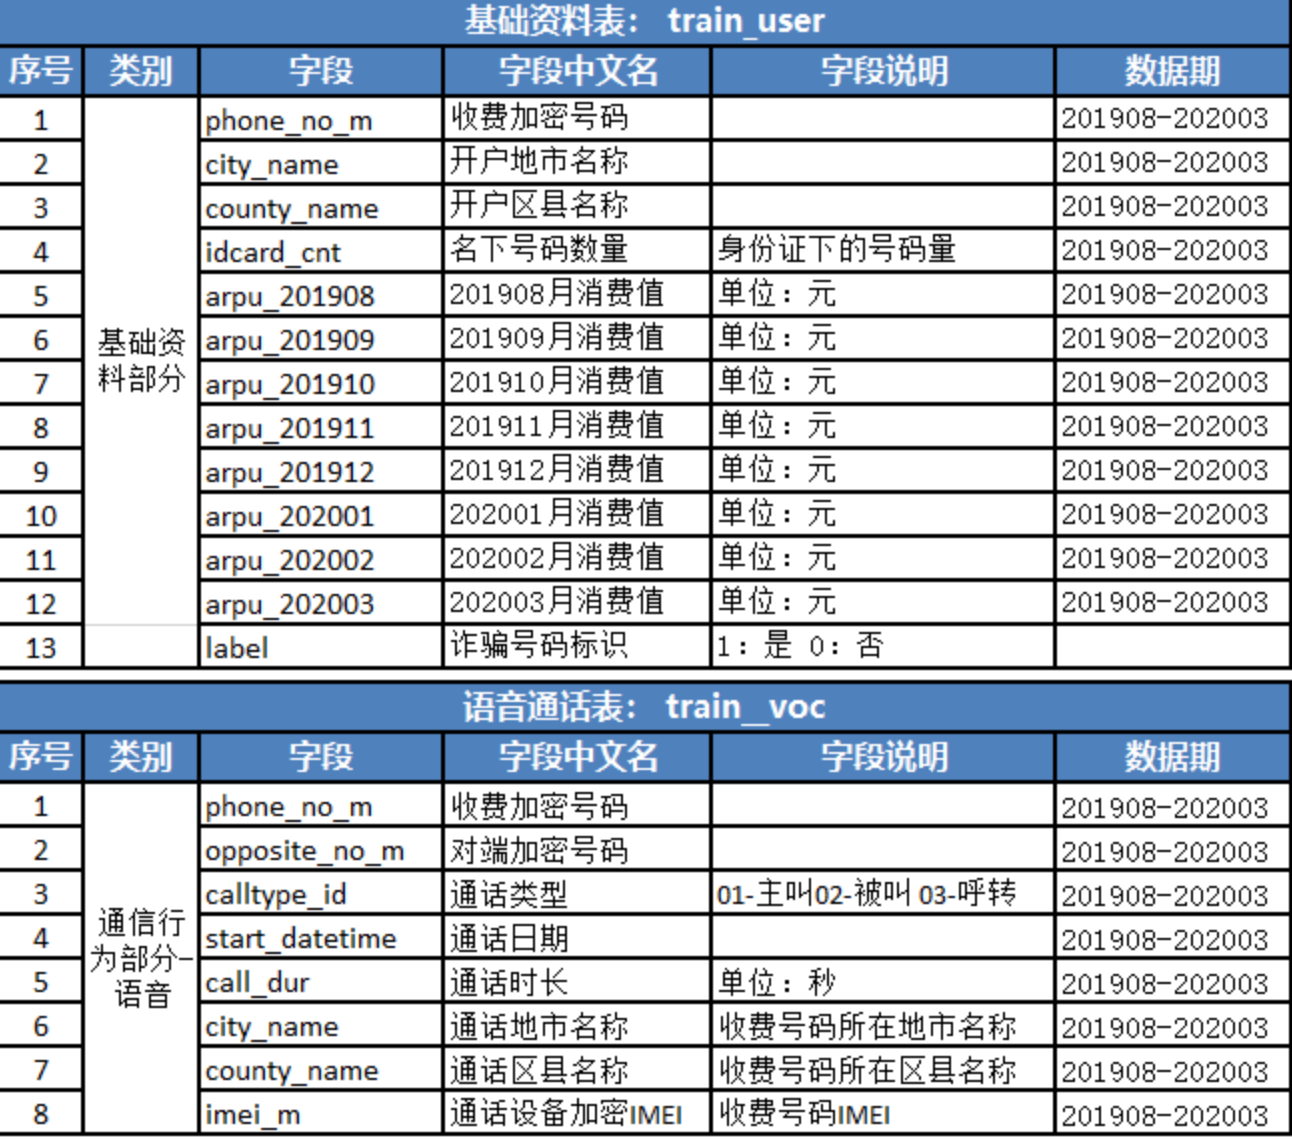

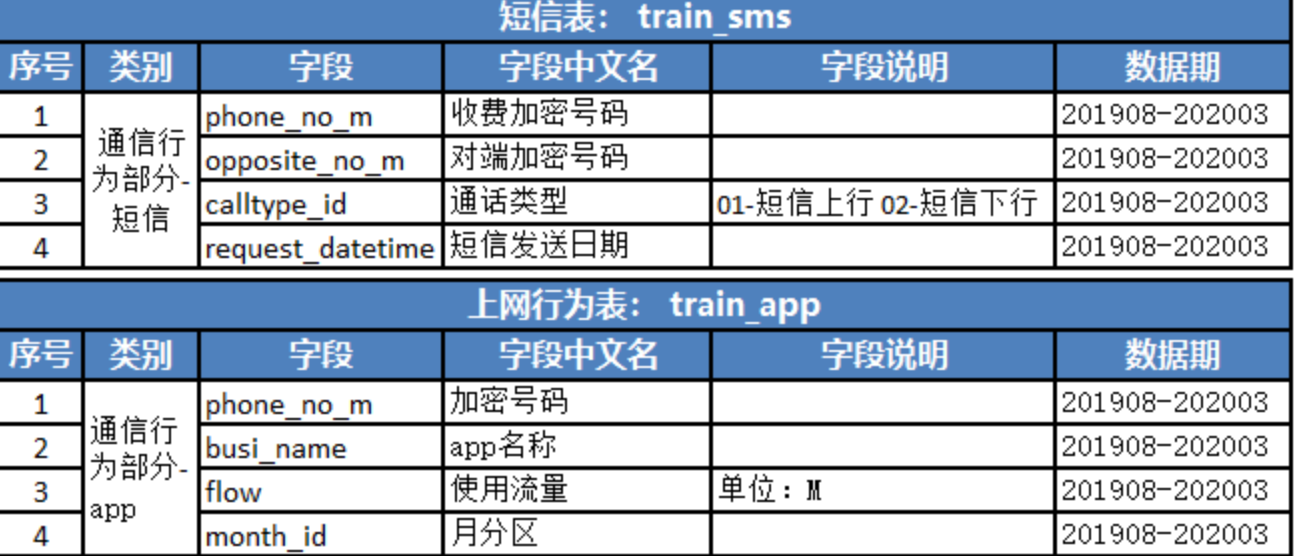

# lib导入

In [1]:
# export
import os
from code.config import * 
from loguru import logger
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行



In [2]:
import sys
sys.path.append('..')
import seaborn as sns
sns.set(font='Arial Unicode MS')  # 解决Seaborn中文显示问题
from mylib.utils.pickle import PickleWrapper

In [3]:
args.DATA_DIR

'../../data/contest/20sichuan_fraudtel_detection/'

In [4]:
!ls ../../data/contest/20sichuan_fraudtel_detection/

submit_example.csv test               train


In [5]:
!ls ../../data/contest/20sichuan_fraudtel_detection/train

train_app.csv  train_sms.csv  train_user.csv train_voc.csv


# load data

In [6]:
train_user = pd.read_csv(os.path.join(args.DATA_DIR, 'train/train_user.csv'))

train_user.head()

,phone_no_m,city_name,county_name,idcard_cnt,arpu_201908,arpu_201909,arpu_201910,arpu_201911,arpu_201912,arpu_202001,arpu_202002,arpu_202003,label
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a...,绵阳,江油分公司,1,46.06,45.00,45.0,45.00,45.00,45.0,45.0,45.0,0
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34d...,德阳,旌阳分公司,1,79.00,79.20,79.1,79.30,41.40,34.1,59.4,60.0,0
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c...,成都,金堂分公司,2,18.85,24.45,22.0,21.40,22.15,21.1,61.3,63.0,0
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f...,成都,高新分公司,2,19.20,29.65,130.4,173.12,19.00,19.0,19.0,23.2,0
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d...,德阳,旌阳分公司,1,50.00,50.00,50.0,50.00,50.00,50.0,50.0,50.0,0


In [7]:
train_user.label.value_counts()

0    4144
1    1962
Name: label, dtype: int64